In [4]:
import numpy as np
import pandas as pd

from fastai.vision.all import *
from fastai.data.all import *

import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import sampler, random_split
from torchvision import models

In [ ]:
directory = './data/images/images/Albrecht_Durer'
path = 'C:\python\SU\data\images\images\Albrecht_Durer\\'
counter = 1

files = os.scandir(directory)

for filename in os.listdir(directory):
    new_name = "Albrecht_Durer_" + str(counter) + ".jpg"
    os.rename(path + filename, path + new_name)
    print(path + filename)
    print(path + new_name)
    print(counter)
    counter = counter + 1
    

In [6]:
!pip freeze > requirements.txt # aktualizace souboru s balicky
torchvision.__version__, torch.__version__ # ('0.14.0+cpu', '1.13.0+cpu')
models.list_models()

('0.14.0+cpu', '1.13.0+cpu')

In [10]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomApply(transforms=[
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
            ], p=0.43),
            transforms.Resize(300),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.75)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        return train_loader, train_data_len
    
    else:
        transform = transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.70)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        return (val_loader, test_loader, valid_data_len, test_data_len)

In [11]:
dataset_path = "./data/images/images/"
dls = ImageDataLoaders.from_folder(dataset_path, valid_pct=0.25, item_tfms=Resize(224))
classes = get_classes(dataset_path)

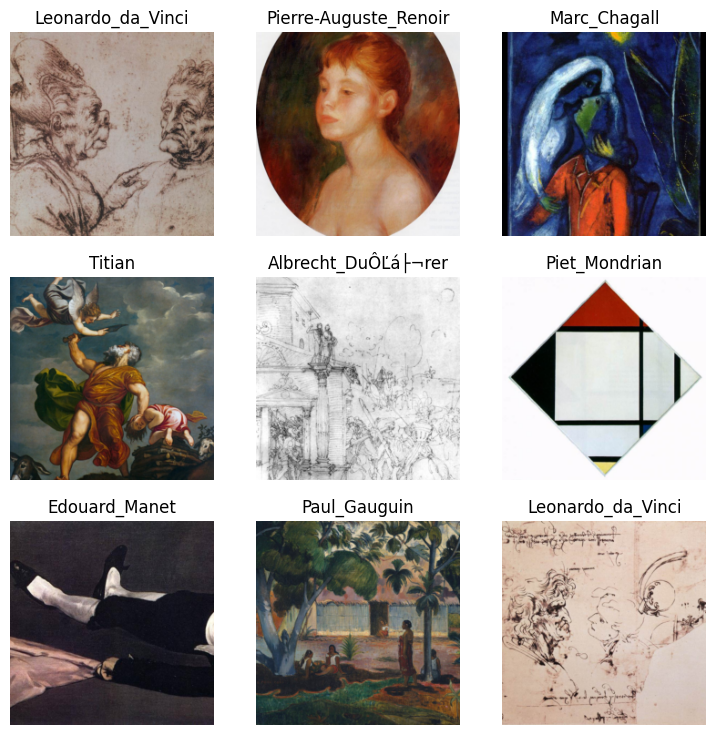

In [14]:
dls.show_batch()

In [31]:
model = models.efficientnet_b1(pretrained=True)
#model = models.mobilenet_v2(pretrained=True)

#print model

In [32]:
for param in model.parameters():
    param.requires_grad = False

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
n_inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs,512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=51, bias=True)
)


In [35]:
criterion = CrossEntropyLossFlat()

In [36]:
learn = Learner(dls, model, loss_func=criterion, metrics=[accuracy, error_rate])

In [37]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.370950,1.919278,0.494300,0.505700,18:01


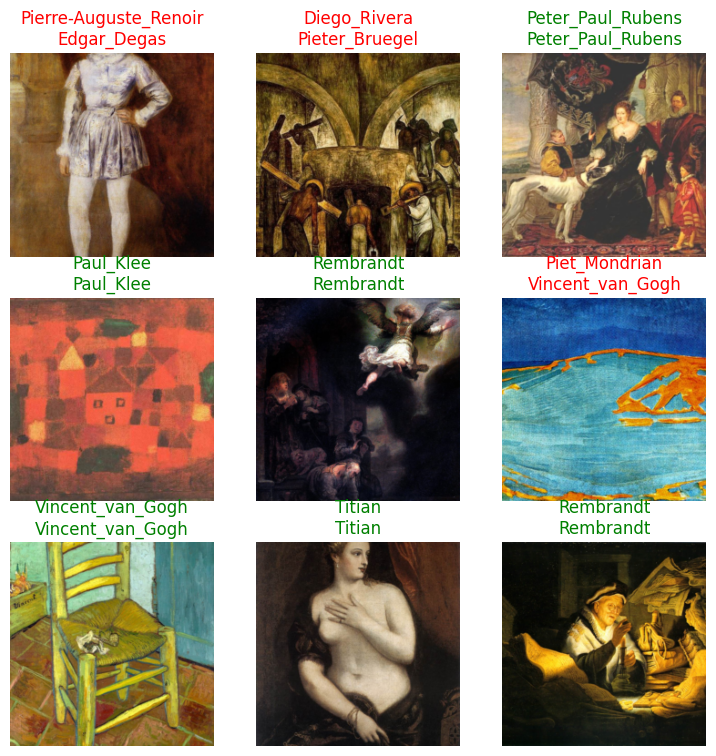

In [38]:
learn.show_results()